# Image Classification with CNN

In this project we will build a convolutional neural network (CNN) to classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). My goal is to demonstrate how easy one can construct a neural network with descent accuracy (around 70%). Thereby, I used only my laptop's i7 processor and a couple of hours training time.

# Image Dataset

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour images in 10 categories - airplanes, dogs, cats, and other objects. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. Here are the classes in the dataset, as well as 10 random images from each:
<img src="files/dataset_overview.jpg">
The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

In the following we will preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  Next we will build a convolutional, max pooling, dropout, and fully connected layers. At the end, we will train the network ang get to see it's predictions on the sample images.

## Download the dataset
First, few lines of code will download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

## Data Overview
The dataset is broken into batches - this is especially useful if one is to train the network on a laptop as it will probably prevent it from running out of memory. I only had 12 GB on mine and a single batch used around 3.2 GB - it wouldn't be possible to load everything at once. Nevertheless, the CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:

* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data. Following functions can be used to view different images by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

In [2]:
import pickle
import matplotlib.pyplot as plt

LABEL_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def load_cfar10_batch(batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' 
              + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels


def display_stats(features, labels, sample_id):
    """
    Display Stats of the the dataset
    """

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'
              .format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, LABEL_NAMES[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)
    plt.show()

Let's check the first couple of images of each batch. The lines below can be easily modified to show an arbitary image from any batch.


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 0:
Image - Min Value: 0 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 6 Name: frog


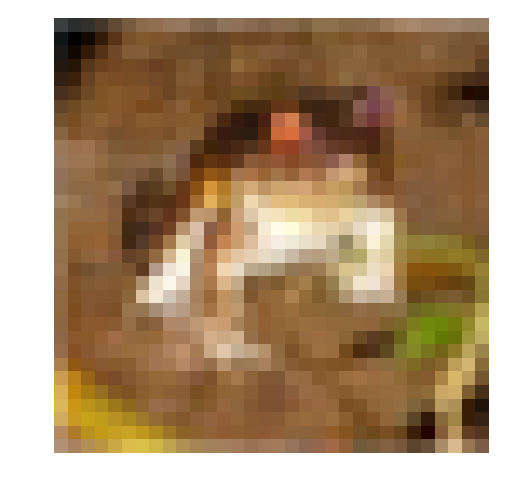


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 1:
Image - Min Value: 5 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 9 Name: truck


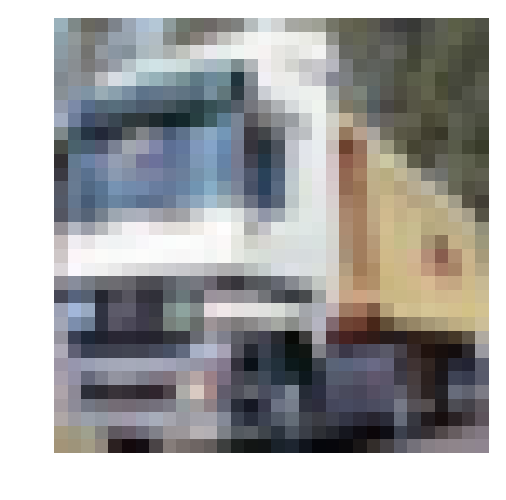


Stats of batch 2:
Samples: 10000
Label Counts: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
First 20 Labels: [1, 6, 6, 8, 8, 3, 4, 6, 0, 6, 0, 3, 6, 6, 5, 4, 8, 3, 2, 6]

Example of Image 0:
Image - Min Value: 5 Max Value: 225
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


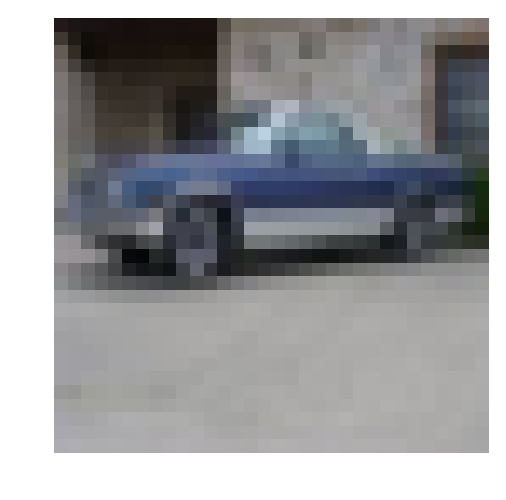


Stats of batch 2:
Samples: 10000
Label Counts: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
First 20 Labels: [1, 6, 6, 8, 8, 3, 4, 6, 0, 6, 0, 3, 6, 6, 5, 4, 8, 3, 2, 6]

Example of Image 1:
Image - Min Value: 2 Max Value: 247
Image - Shape: (32, 32, 3)
Label - Label Id: 6 Name: frog


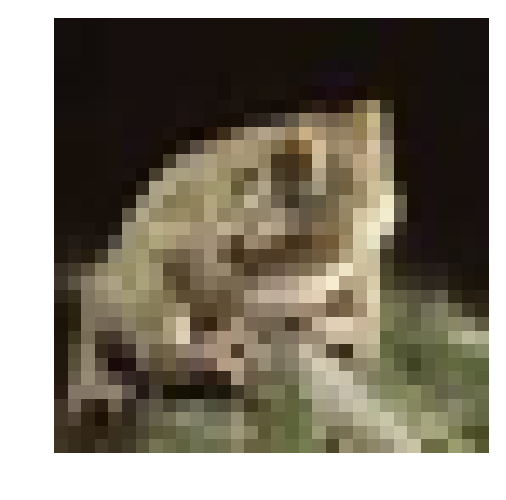


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 0:
Image - Min Value: 0 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 8 Name: ship


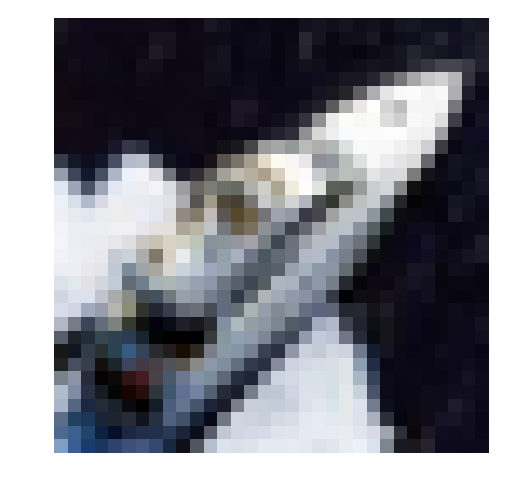


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 1:
Image - Min Value: 15 Max Value: 249
Image - Shape: (32, 32, 3)
Label - Label Id: 5 Name: dog


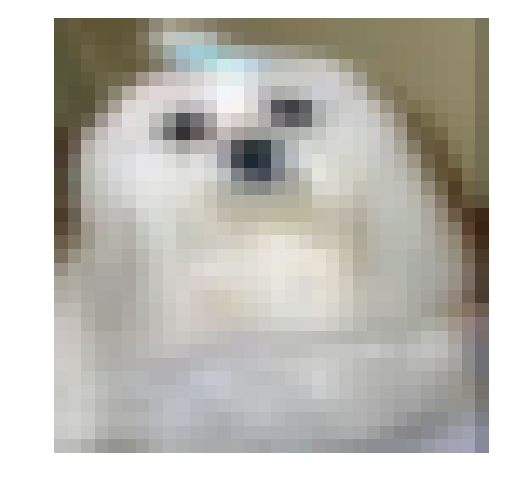


Stats of batch 4:
Samples: 10000
Label Counts: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
First 20 Labels: [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1]

Example of Image 0:
Image - Min Value: 34 Max Value: 203
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


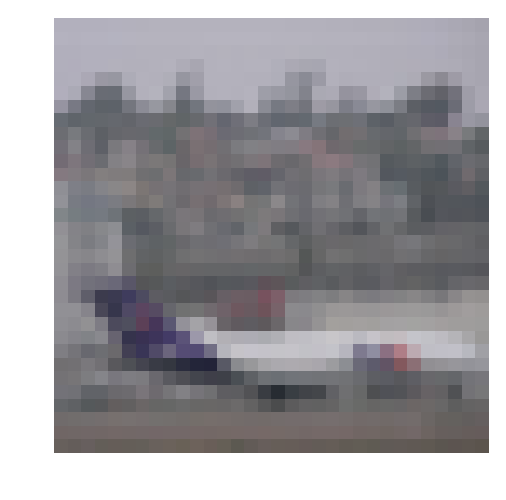


Stats of batch 4:
Samples: 10000
Label Counts: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
First 20 Labels: [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1]

Example of Image 1:
Image - Min Value: 0 Max Value: 246
Image - Shape: (32, 32, 3)
Label - Label Id: 6 Name: frog


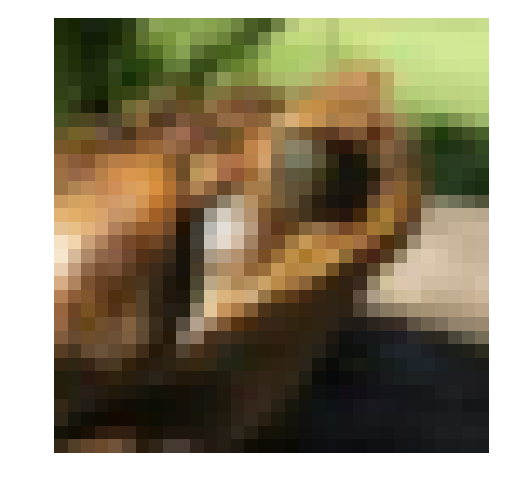


Stats of batch 5:
Samples: 10000
Label Counts: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}
First 20 Labels: [1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8]

Example of Image 0:
Image - Min Value: 2 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


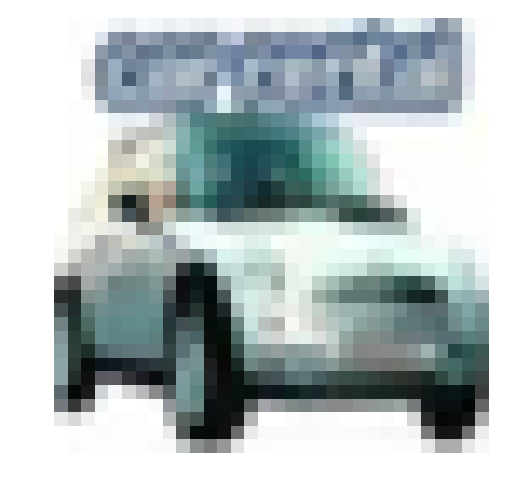


Stats of batch 5:
Samples: 10000
Label Counts: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}
First 20 Labels: [1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8]

Example of Image 1:
Image - Min Value: 1 Max Value: 244
Image - Shape: (32, 32, 3)
Label - Label Id: 8 Name: ship


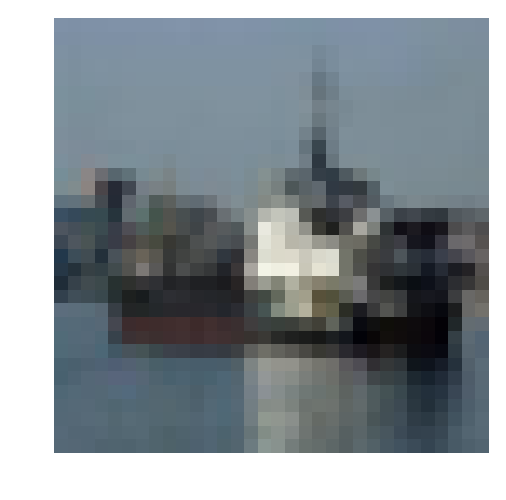

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

for batch_id in range(1,6):
    features, labels = load_cfar10_batch(batch_id)
    for image_id in range(0,2):
        display_stats(features, labels, image_id)

del features, labels # free memory       

## Preprocess data

### Normalization function

In the cell below, the `normalize` function takes in image data, `x`, and return it as a normalized Numpy array. The values are in the range of 0 to 1, inclusive. The return object has the same shape as `x`.

In [4]:
def normalize(x):
    # Each pixel has three channels - Red, Green and Blue. 
    # Each channel is an int between 0 and 255 (8-bit color scheme). 
    return np.array(x) / 255.0

### One-hot-encoding
Not only the input data, but also the labels have to be preprocessed. When dealing with categorical data one has to one-hot-encode the labels. Normally, I would use the [OneHotEncoder from the sklearn.preprocessing library](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). For the sake of example, I implemented it by myself. 

In [5]:
def one_hot_encode(x):
    one_hot_encoded = np.zeros((len(x), 10))
    for i in range(len(x)):
        one_hot_encoded[i][x[i]] = 1.0
    return one_hot_encoded

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation. Remember, we do not want to load all the data in the memory simulanously.

In [6]:
"""
Preprocess Training and Validation and Test Data
"""

def preprocess_and_save(features, labels, filename):
    """
    Preprocess data and save it to file
    Both functions have been defined above
    """
    features = normalize(features) 
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))

def preprocess_and_save_all_data():
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(batch_i)
        validation_count = int(len(features) * 0.1)

        # Prprocess and save a batch of training data
        preprocess_and_save(
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    # Preprocess and Save all validation data
    preprocess_and_save(
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the training data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all training data
    preprocess_and_save(
        np.array(test_features),
        np.array(test_labels),
        'preprocess_training.p')

# Run preprocessing and saving on disk
preprocess_and_save_all_data()

## Building the neural network
For the neural network, I will build each type of layer into a function. Encapsulating tensorflow logic in such functions allows you to easily modify the architectire without having to rewrite the boilerplate tensorflow code. Furthermore, the functions built can be later reused for other datasets containing images with different size and different labels.

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. 

In [7]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    return tf.placeholder(tf.float32, shape=(None, image_shape[0], image_shape[1], image_shape[2]), name='x')

def neural_net_label_input(n_classes):
    return tf.placeholder(tf.float32, shape=(None, n_classes), name='y')

def neural_net_keep_prob_input():
    return tf.placeholder(tf.float32, name='keep_prob')

### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. The following block of code implements the function `conv2d_maxpool` to apply convolution and then max pooling. Applying convolutions and then max pooling has become a "de facto" standard for constructing neural networks for image recognition. It is generally a nice idea to log the layer's input and output dimensions - the two print functions at the end will be useful when fine tuning the network architecture. 

In [8]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
   
    # Create filter dimensions
    filter_height, filter_width, in_channels, out_channels = \
        conv_ksize[0], conv_ksize[1],  x_tensor.get_shape().as_list()[3], conv_num_outputs
    conv_filter = [filter_height, filter_width, in_channels, out_channels]
    
    # Create weights and bias
    weights = tf.Variable(tf.truncated_normal(conv_filter, stddev=0.05))
    bias = tf.Variable(tf.truncated_normal([conv_num_outputs], stddev=0.05))
    
    # Create strides
    strides=(1,conv_strides[0], conv_strides[1], 1)
    
    # Bind all together to create the layer
    conv = tf.nn.conv2d(x_tensor, weights, strides, padding='SAME')
    conv = tf.nn.bias_add(conv, bias)
    
    # Create ksize 
    ksize = (1, pool_ksize[0], pool_ksize[1], 1)
    
    # Create strides
    strides=(1,pool_strides[0], pool_strides[1], 1)
    
    pool = tf.nn.max_pool(conv, ksize, strides, padding='SAME')
    
    print('Convolutional layer with conv_num_outputs:',conv_num_outputs,
          'conv_ksize:', conv_ksize,
          'conv_strides:', conv_strides,
          'pool_ksize:',pool_ksize,
          'pool_strides', pool_strides)
    print('layer input shape', x_tensor.get_shape().as_list(),
          'layer output shape', pool.get_shape().as_list())
    
    return pool

### Flatten Layer and Fully Connected Layers
After stacking up the convolution layers one usually flattens the network and applies at least one, but usually several fully connected layers. Dropout is also applied at this point. As a matter of fact, dropout is one of the great discoveries in the last years. It is used to prevent the network from overfitting.

In [9]:
def flatten(x_tensor):
    _, height, width, channels = x_tensor.get_shape().as_list()
    net = tf.reshape(x_tensor, shape=[-1, height * width * channels])
    print('flatten shape', net.get_shape().as_list())
    return net

def fully_conn(x_tensor, num_outputs):
    _, size = x_tensor.get_shape().as_list()
    weights = tf.Variable(tf.truncated_normal([size, num_outputs], stddev=0.05))
    bias = tf.Variable(tf.truncated_normal([num_outputs], stddev=0.05))
    
    fully_connected = tf.add(tf.matmul(x_tensor, weights), bias)
    
    print('layer input shape', x_tensor.get_shape().as_list(),
         'layer output shape', fully_connected.get_shape().as_list())
    
    return fully_connected

### The Neural Network architecture
In the function `conv_net` we create the actual convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits. The layers introduced above are bound together. This is where one actually defines the architecture of the neural network. As a matter of fact, I changed the architecture more than a dozen of times, until I reached a reasonable accuracy. Indeed, it is very hard to choose a proper architecture and blind trail and error is not the way to go here. There are multiple methodologies for finetuning a neural network described in various papers by the scientific community. For the sake of simplicity I will not dive into the details here, but would definetly recommend this reading: [1st place on the Galaxy Zoo Challenge](http://benanne.github.io/2014/04/05/galaxy-zoo.html)

In [10]:
def conv_net(input_x, keep_probability):
    
    net = conv2d_maxpool(input_x,   32, (7,7), (2,2), (2,2), (2,2))
    net = conv2d_maxpool(net, 64, (3,3), (1,1), (2,2), (2,2))
    net = conv2d_maxpool(net, 128, (2,2), (1,1), (2,2), (2,2))
    
    net = flatten(net)
    net = tf.nn.dropout(net, keep_probability)
    net = fully_conn(net, 1024)
    net = tf.nn.dropout(net, keep_probability)
    net = fully_conn(net, 128)
    net = fully_conn(net, 10)

    return net

### Building the Neural Network
In the code block below we use tensorflow to train the neural network. I found the AdamOptimizer to be the least sensitive to the learning rate. The learning rate is another parameter one has to tune. For an overview of diffent optimizers check [An overview of gradient descent optimization algorithms.](http://sebastianruder.com/optimizing-gradient-descent/)

In [11]:
##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

IMAGE_SHAPE = (32, 32, 3)
LABELS_COUNT = 10

# Inputs
x = neural_net_image_input(IMAGE_SHAPE)
y = neural_net_label_input(LABELS_COUNT)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Convolutional layer with conv_num_outputs: 32 conv_ksize: (7, 7) conv_strides: (2, 2) pool_ksize: (2, 2) pool_strides (2, 2)
layer input shape [None, 32, 32, 3] layer output shape [None, 8, 8, 32]
Convolutional layer with conv_num_outputs: 64 conv_ksize: (3, 3) conv_strides: (1, 1) pool_ksize: (2, 2) pool_strides (2, 2)
layer input shape [None, 8, 8, 32] layer output shape [None, 4, 4, 64]
Convolutional layer with conv_num_outputs: 128 conv_ksize: (2, 2) conv_strides: (1, 1) pool_ksize: (2, 2) pool_strides (2, 2)
layer input shape [None, 4, 4, 64] layer output shape [None, 2, 2, 128]
flatten shape [None, 512]
layer input shape [None, 512] layer output shape [None, 1024]
layer input shape [None, 1024] layer output shape [None, 128]
layer input shape [None, 128] layer output shape [None, 10]


### Show Stats
We also need to implement a function to print loss and validation accuracy. Additionally, we define the global variables `valid_features` and `valid_labels` to calculate validation accuracy. Remember to always use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [12]:
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

def print_stats(session, feature_batch, label_batch, cost, accuracy):
    batch_loss = session.run(cost, feed_dict=\
                    {x:feature_batch, y:label_batch, keep_prob:1.0})
    batch_accuracy = session.run(accuracy, feed_dict=\
                    {x:valid_features, y:valid_labels, keep_prob:1.0})
    
    print('batch loss is : ', batch_loss)
    print('batch_accuracy accuracy is :',batch_accuracy)

### Hyperparameters

A few more parameters need to be tuned:
* We set `epochs` to the number of iterations until the network stops learning or starts overfitting
* We Set `batch_size` to the highest number that your machine has memory for.  Most people set them to common sizes of memory like 64, 128, etc. The bigger the batch size, the less epochs are needed for the network to be trained. 


* We set `keep_probability` to the probability of keeping a node using dropout. Hence, keep_probability prevents overfitting of the neural network. Usually values between 0.4 and 0.8 produce good results. 

In [13]:
# For my laptop I selected:
epochs = 50
batch_size = 256

# keep probability of 70% 
keep_probability = 0.5

In [14]:
# a couple of helper functions for loading a single batch
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]
        
def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This saved me a lot of time while iterating the parameters of the model to get a better accuracy. Once I found the final validation accuracy to be satisfying I ran the model on all the data.

In [15]:
print('Checking the Training on a Single Batch...')
with tf.Session() as session:
    # Initializing the variables
    session.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in \
            load_preprocess_training_batch(batch_i, batch_size):
            session.run(optimizer, feed_dict=\
                        {x:batch_features, y:batch_labels, keep_prob:keep_probability})
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(session, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  batch loss is :  2.04934
batch_accuracy accuracy is : 0.3524
Epoch  2, CIFAR-10 Batch 1:  batch loss is :  1.80641
batch_accuracy accuracy is : 0.4126
Epoch  3, CIFAR-10 Batch 1:  batch loss is :  1.54692
batch_accuracy accuracy is : 0.4486
Epoch  4, CIFAR-10 Batch 1:  batch loss is :  1.27744
batch_accuracy accuracy is : 0.4792
Epoch  5, CIFAR-10 Batch 1:  batch loss is :  1.13442
batch_accuracy accuracy is : 0.4928
Epoch  6, CIFAR-10 Batch 1:  batch loss is :  0.92034
batch_accuracy accuracy is : 0.496
Epoch  7, CIFAR-10 Batch 1:  batch loss is :  0.806121
batch_accuracy accuracy is : 0.4896
Epoch  8, CIFAR-10 Batch 1:  batch loss is :  0.745746
batch_accuracy accuracy is : 0.5048
Epoch  9, CIFAR-10 Batch 1:  batch loss is :  0.615836
batch_accuracy accuracy is : 0.531
Epoch 10, CIFAR-10 Batch 1:  batch loss is :  0.497367
batch_accuracy accuracy is : 0.5288
Epoch 11, CIFAR-10 Batch 1:  batch loss is :  0.442382


### Fully Train the Model
Now that we got a good accuracy with a single CIFAR-10 batch, we train the model again by using all five batches. This takes quite a lot of time. At the end the model is saved on the hard disk in order to be reused in the future.

In [16]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as session:
    # Initializing the variables
    session.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in \
                load_preprocess_training_batch(batch_i, batch_size):
                session.run(optimizer, feed_dict=\
                    {x:batch_features, y:batch_labels, keep_prob:keep_probability})
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(session, save_model_path)

Training...


## Test Model
At the end we load the model from the disk and use it to test against the test dataset. This will produce our final accuracy estimation.

Testing Accuracy: 0.6734375



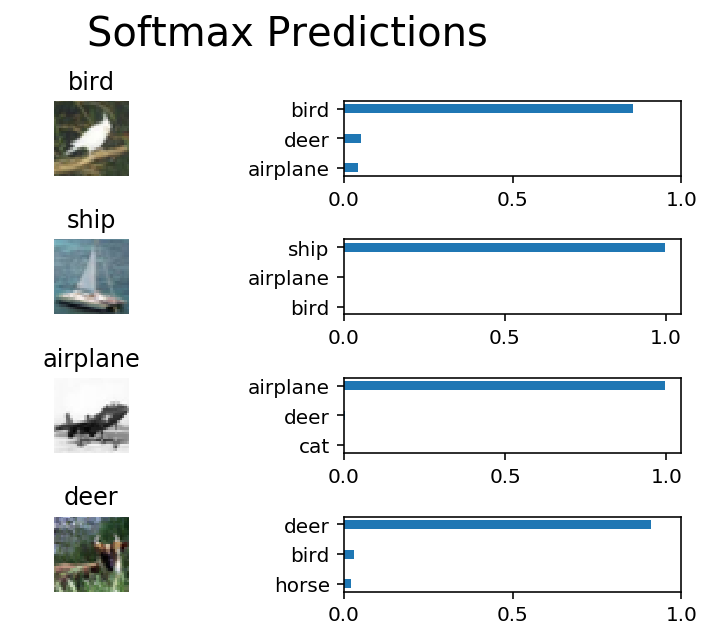

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

def display_image_predictions(features, labels, predictions):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(LABELS_COUNT))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) \
        in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [LABEL_NAMES[pred_i] for pred_i in pred_indicies]
        correct_name = LABEL_NAMES[label_id]

        axies[image_i][0].imshow(feature)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in \
            batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, \
                           loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = \
            tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, \
                       loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        display_image_predictions(random_test_features, \
                                  random_test_labels, random_test_predictions)


test_model()